In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/VZ.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,53.570000,52.799999,53.160000,53.529999,16045300.0,45.982079
2018-01-03,53.340000,52.180000,53.299999,52.430000,16662400.0,45.037197
2018-01-04,52.889999,51.830002,52.369999,52.599998,12062800.0,45.183224
2018-01-05,52.880001,52.349998,52.799999,52.480000,13348900.0,45.080143
2018-01-08,52.750000,52.040001,52.560001,52.389999,16212700.0,45.002834


In [3]:
dataset.count()

High         838
Low          838
Open         838
Close        838
Volume       838
Adj Close    838
dtype: int64

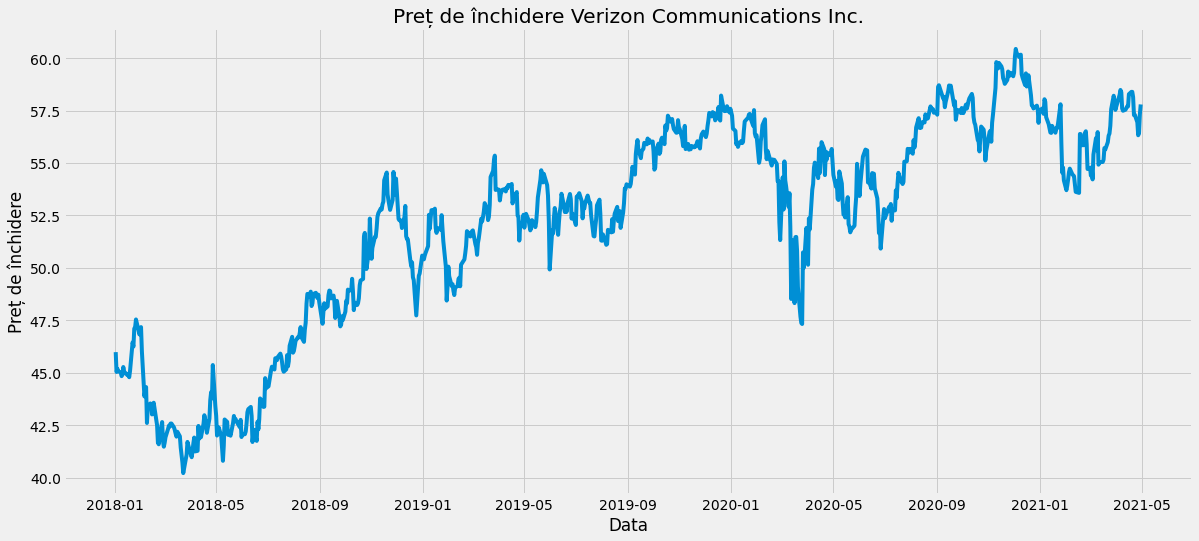

In [4]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere Verizon Communications Inc.')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

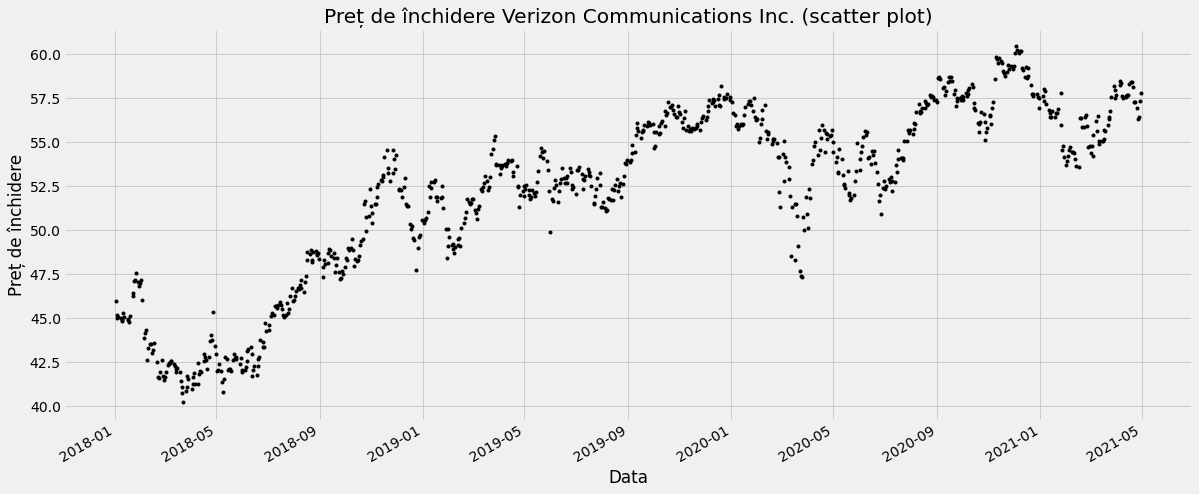

In [5]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere Verizon Communications Inc. (scatter plot)')
plt.show

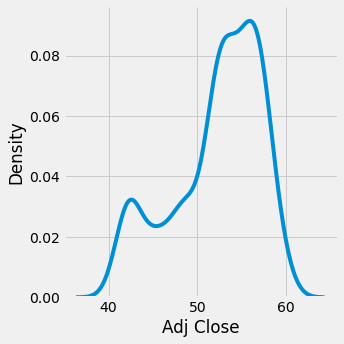

In [6]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

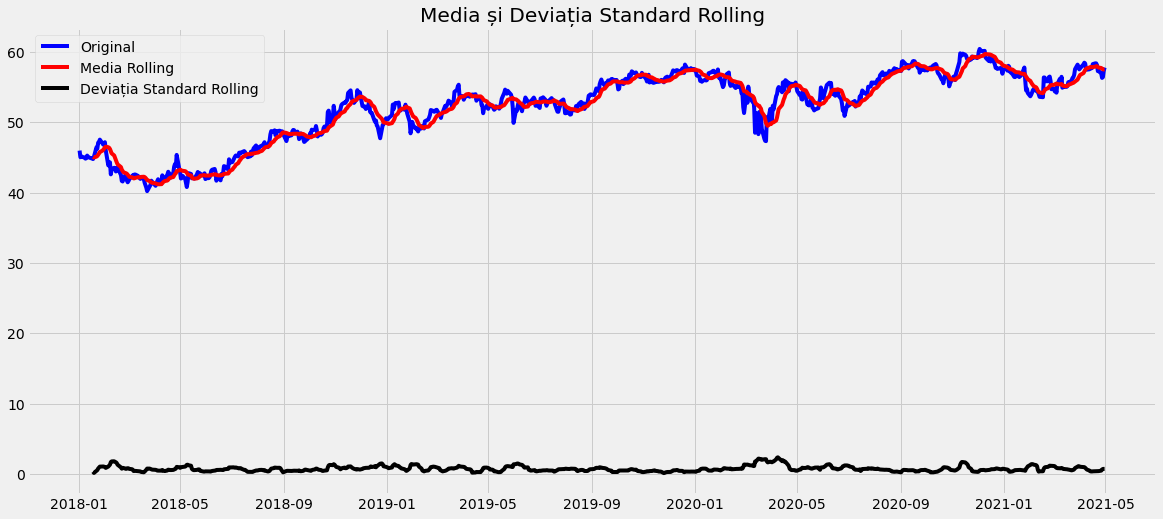

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic            -1.676923
p-value                    0.443040
Nr. decalaje folosite     10.000000
Nr. observatii           827.000000
valoare critica (1%)      -3.438282
valoare critica (5%)      -2.865041
valoare critica (10%)     -2.568634
dtype: float64


In [7]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

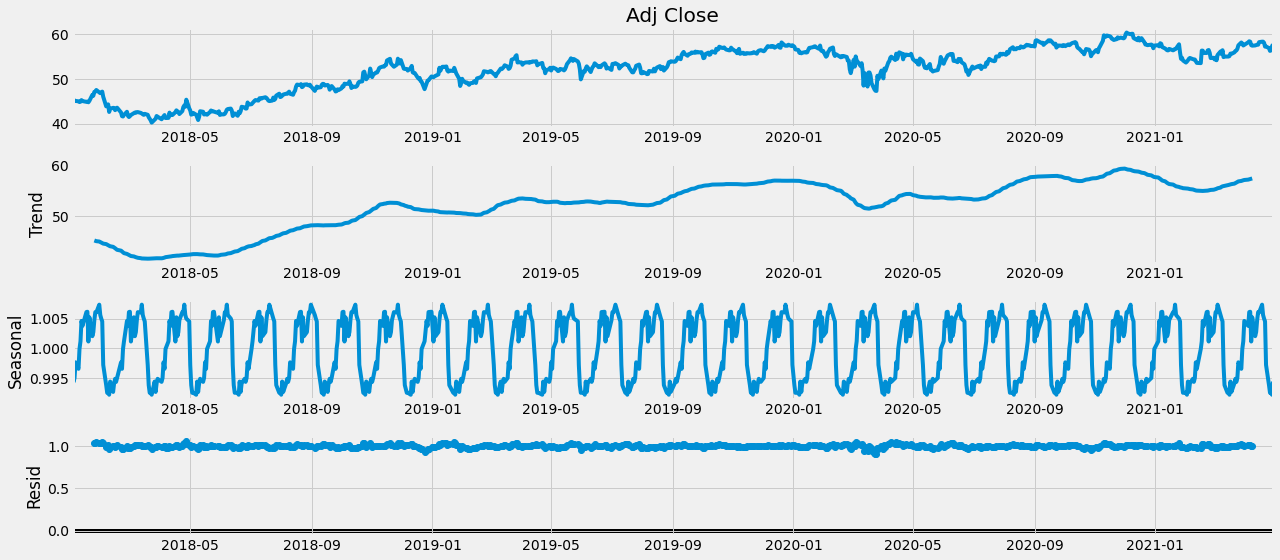

In [8]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

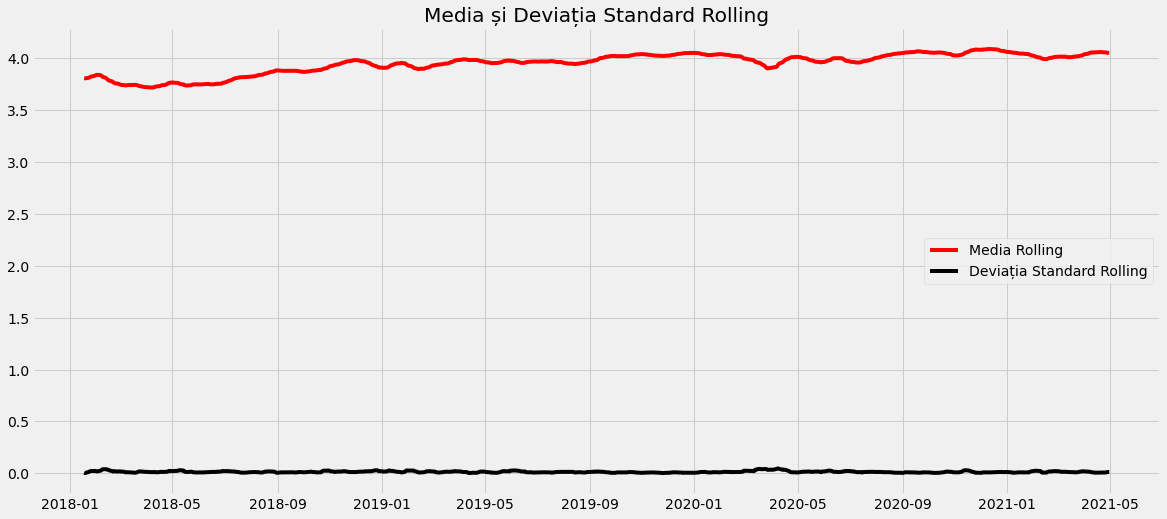

In [9]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

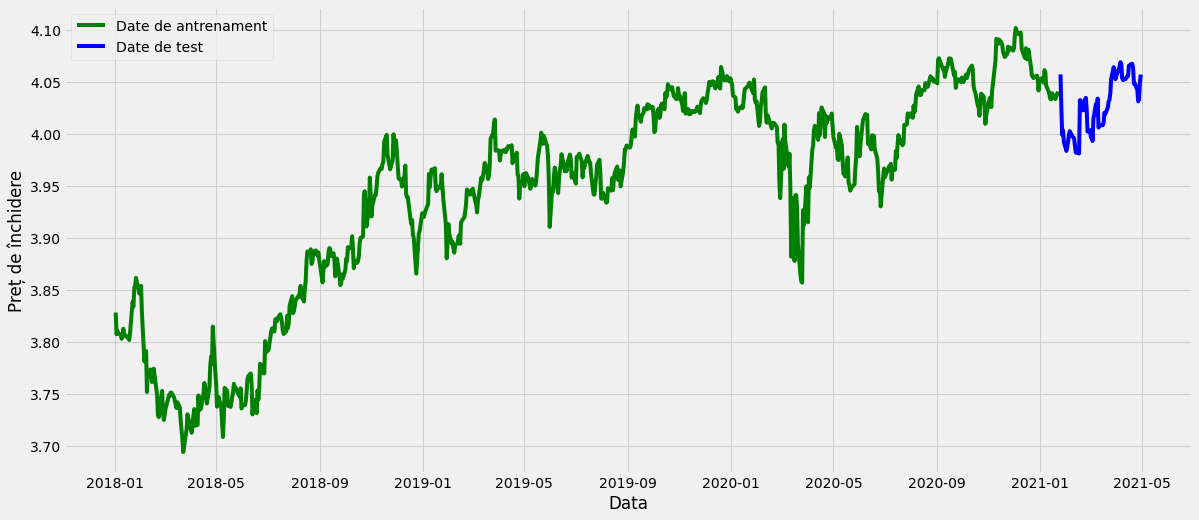

In [10]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [11]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=4, max_q=4,
                        m=1,
                        d=None,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4513.552, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4529.314, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4529.159, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4515.196, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4527.315, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4527.315, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4525.317, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4530.821, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4528.821, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4528.821, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4530.642, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4526.821, Time=0.46 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.658 seconds
                               SARIMAX Results                              

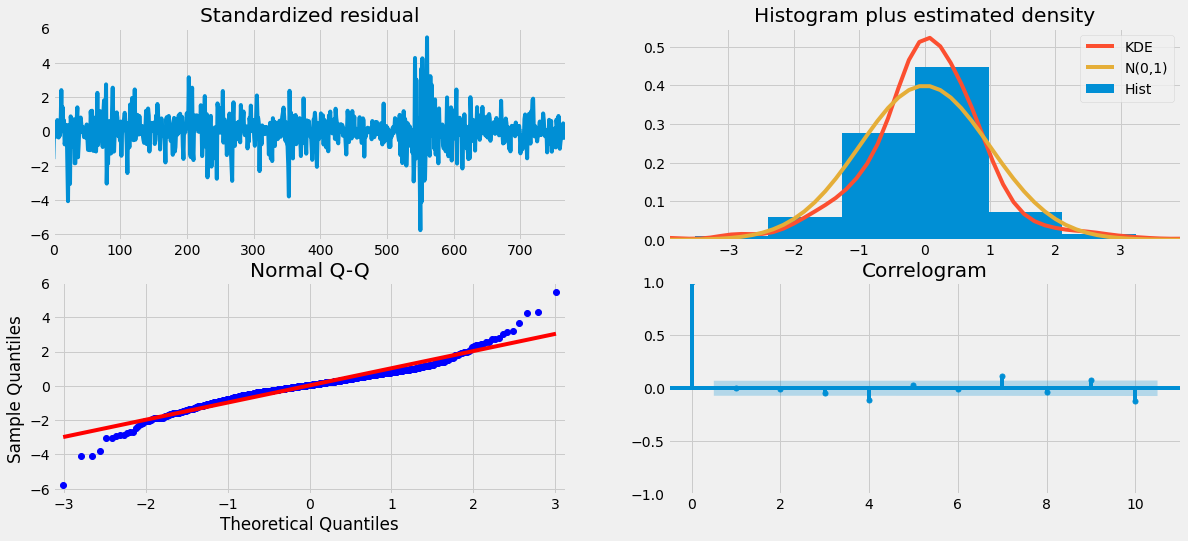

In [12]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [13]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(1, 1, 0))  
fitted = model.fit(disp=-1, trend = 'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  769
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2267.410
Method:                       css-mle   S.D. of innovations              0.013
Date:                Sun, 20 Jun 2021   AIC                          -4530.821
Time:                        15:27:56   BIC                          -4521.531
Sample:                             1   HQIC                         -4527.245
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close    -0.1507      0.036     -4.223      0.000      -0.221      -0.081
                                    Roots                                    
                  Real          

In [14]:
first_diff = train_data - train_data.shift(1)
first_diff = first_diff.dropna(inplace = False)
first_diff

Date
2018-01-03   -0.020763
2018-01-04    0.003237
2018-01-05   -0.002284
2018-01-08   -0.001716
2018-01-09   -0.003675
                ...   
2021-01-15    0.005943
2021-01-19   -0.005768
2021-01-20    0.003674
2021-01-21    0.000175
2021-01-22    0.003486
Name: Adj Close, Length: 769, dtype: float64

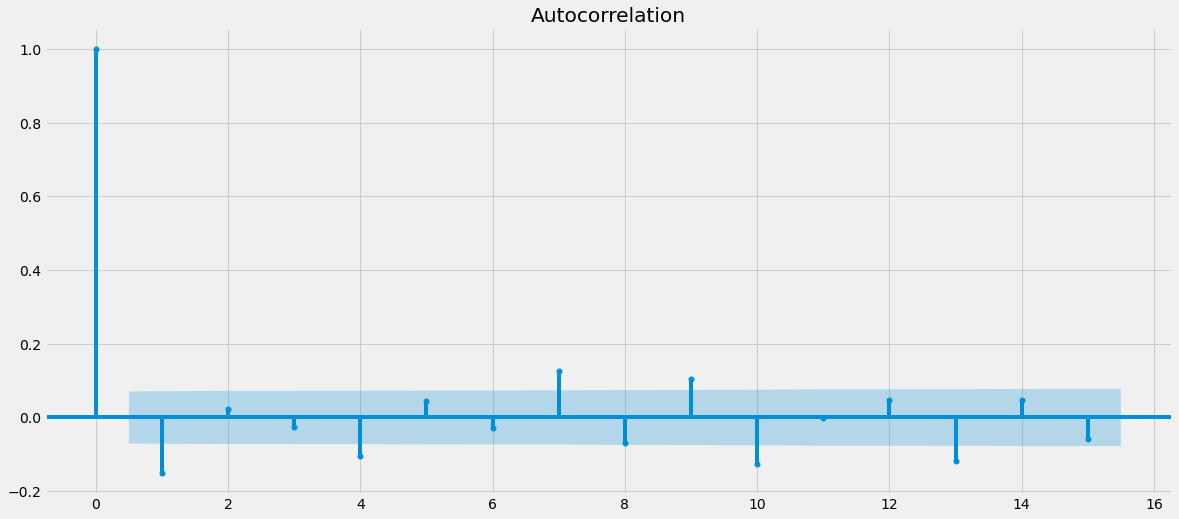

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_plot = plot_acf(first_diff,lags = 15)

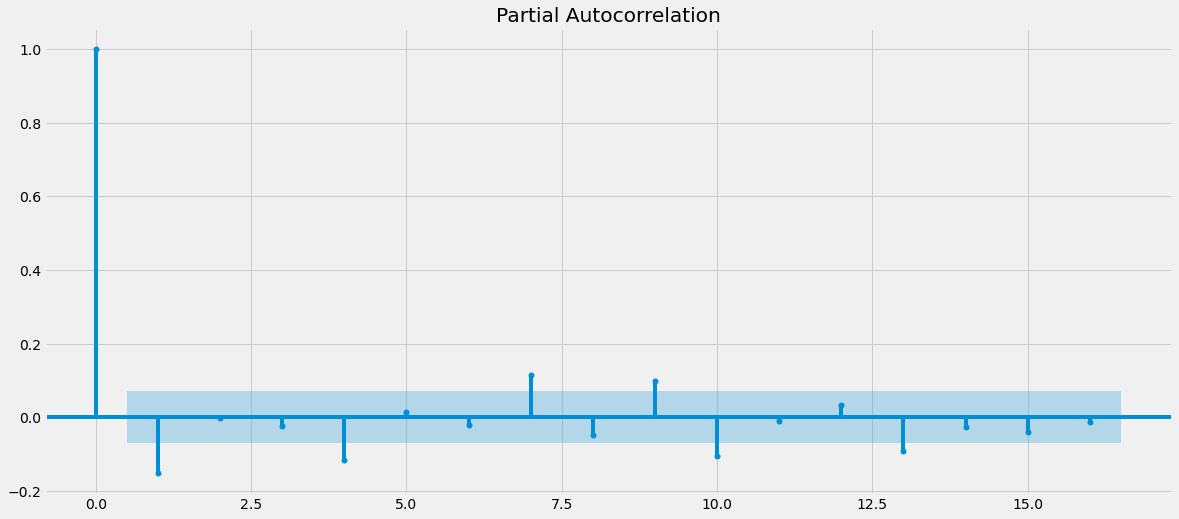

In [16]:
pacf_plot = plot_pacf(first_diff, lags=16)

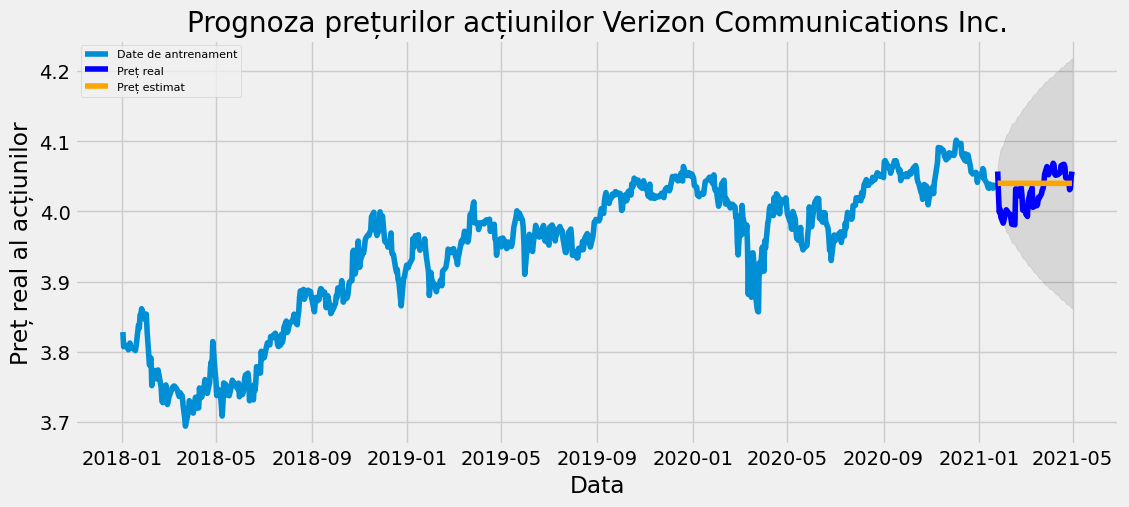

In [17]:
fc, se, conf = fitted.forecast(68, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor Verizon Communications Inc.')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 2.6302368754698224
MAE: 1.3869635157338664
RMSE: 1.62180050421432
MAPE: 2.5008136695787044
